In [6]:
!pip3 install python-igraph==0.8.3

In [5]:
!pip3 install implicit

In [1]:
import igraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from collections import Counter
import implicit
import json

In [3]:
with open("../search_engine/tweets.json", "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]
df_tweets = pd.DataFrame.from_records(data)

NameError: name 'json' is not defined

In [3]:
df_tweets_prueba = df_tweets[:5000]
pd.set_option('display.max_columns', 0)
df_tweets_prueba.head()

,created_at,id,id_str,text,truncated,entities,extended_entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,quoted_status_id,quoted_status_id_str,quoted_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,withheld_in_countries
0,Fri Dec 04 23:06:40 +0000 2020,1334997579436855305,1334997579436855305,Step right up #ObamaNation #BlackLivesMatter 💉...,False,"{'hashtags': [{'text': 'ObamaNation', 'indices...","{'media': [{'id': 1334997080570466304, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 20169447, 'id_str': '20169447', 'name':...",None,None,None,None,True,1.334755e+18,1334754557193281538,{'created_at': 'Fri Dec 04 07:00:59 +0000 2020...,0,0,False,False,False,en,NaN,NaN
1,Fri Dec 04 23:06:17 +0000 2020,1334997483689152513,1334997483689152513,RT @TeressaLRaiford: My daughter makes me prou...,False,"{'hashtags': [{'text': 'SITU', 'indices': [59,...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 1100537752796377088, 'id_str': '1100537...",None,None,None,None,False,NaN,NaN,NaN,2,0,False,False,NaN,en,{'created_at': 'Fri Dec 04 22:39:24 +0000 2020...,NaN
2,Fri Dec 04 23:06:06 +0000 2020,1334997434498490372,1334997434498490372,@McmlixM That comes after President Trump is d...,False,"{'hashtags': [{'text': 'Antifa', 'indices': [1...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.334997e+18,1334996767042134016,1.266243e+18,1266242957901881349,McmlixM,"{'id': 166965005, 'id_str': '166965005', 'name...",None,None,None,None,False,NaN,NaN,NaN,0,0,False,False,NaN,en,NaN,NaN
3,Fri Dec 04 23:05:55 +0000 2020,1334997389862637568,1334997389862637568,RT @ProfJenkins_: “Our lives begin to end the ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 439548120, 'id_str': '439548120', 'name...",None,None,None,None,False,NaN,NaN,NaN,8,0,False,False,NaN,en,{'created_at': 'Fri Dec 04 21:53:37 +0000 2020...,NaN
4,Fri Dec 04 23:05:52 +0000 2020,1334997379339218947,1334997379339218947,❌Cancel the Democratic Party! ❌ https://t.co/2...,True,"{'hashtags': [{'text': 'CancelCulture', 'indic...","{'media': [{'id': 1134494997569363968, 'id_str...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 1301145862077325312, 'id_str': '1301145...",None,None,None,None,False,NaN,NaN,NaN,0,0,False,False,False,en,NaN,NaN


In [4]:
#df_tweets_prueba.to_csv('prueba.csv', index = False)

In [5]:
def create_graph(data, user_column, retweeted_user_column): #in this case 'user' and 'user_in_reply_to_screen_name'
    graph = {}
    for i in data.index:
        if data.loc[i][retweeted_user_column] != None:
            #the user is new retweeting
            if data.loc[i][user_column]['screen_name'] not in list(graph.keys()):
                graph[data.loc[i][user_column]['screen_name']] = [data.loc[i][retweeted_user_column]]
            #if it is an existent user but the retweeted user is not in in its list
            elif data.loc[i][retweeted_user_column] not in graph[data.loc[i][user_column]['screen_name']]:
                graph[data.loc[i][user_column]['screen_name']].append(data.loc[i][retweeted_user_column])
            #if the user is in the graph and it has previously retweeted a tweet of that user
            else:
                continue
    return graph

In [6]:
graph = create_graph(df_tweets, 'user', 'in_reply_to_screen_name')
#graph

In [7]:
g = igraph.Graph()
g.add_vertices(list(set(list(graph.keys()) + list([a for value in graph.values() for a in value]))))
g.add_edges([(key, value) for key in graph.keys() for value in graph[key]])

In [8]:
g2 = igraph.Graph()
g2.add_vertices(list(set(list(graph.keys()) + list([a for value in graph.values() for a in value]))))
g2.add_edges([(key, value) for key in graph.keys() for value in graph[key]])

This next cell shows the graph

There are 668 self retweeted users.


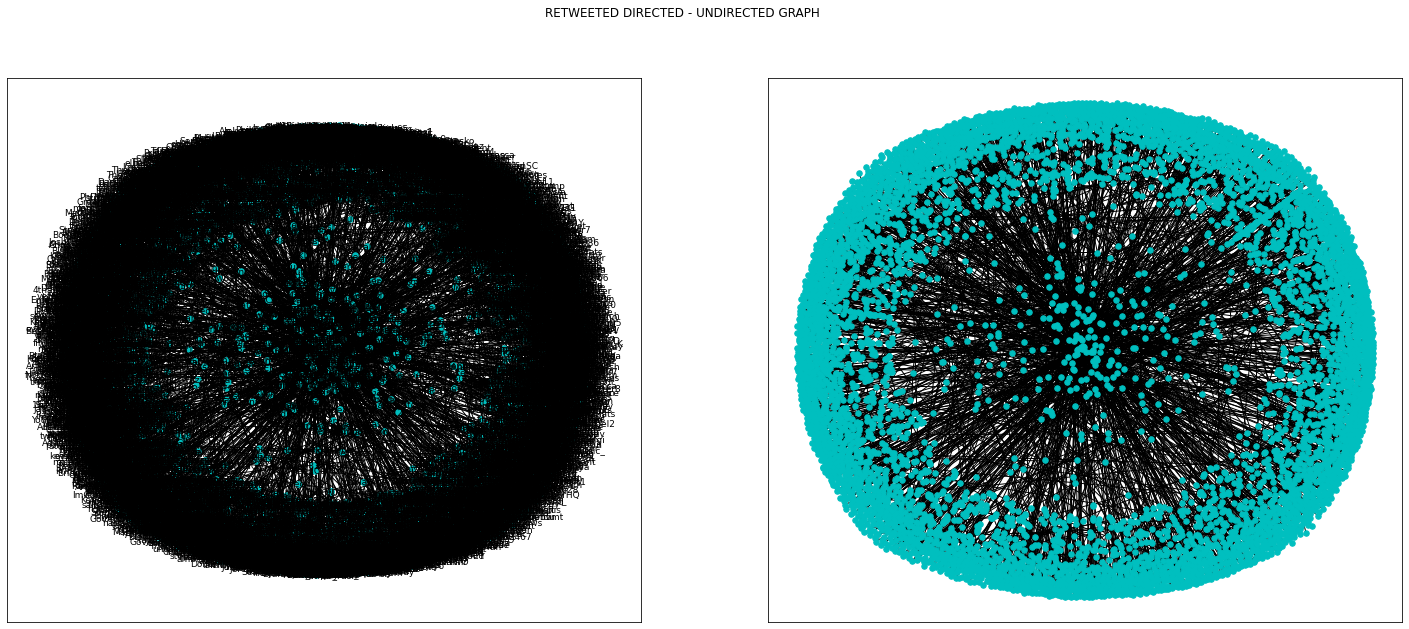

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

#directed
aux = nx.DiGraph(graph)
plt.subplots(nrows=1, ncols = 2, figsize = (25,10))
pos=nx.spring_layout(aux)
plt.subplot(1, 2, 1)
nx.draw_networkx(aux, pos, with_labels=True, node_size=30, node_color='c', font_size = 9)

#undirected
G2 = aux.to_undirected()
plt.suptitle('RETWEETED DIRECTED - UNDIRECTED GRAPH')
#pos=nx.spring_layout(G2)
plt.subplot(1, 2, 2)
nx.draw_networkx(G2, pos, with_labels=False, node_size=30, node_color='c', font_size = 9)


countselfref = 0
nodepairs = []
for key, value in graph.items():
    if key in value:
        countselfref += 1
    for i in range(len(value)):
        nodepairs.append((key, value[i]))
print('There are {} self retweeted users.'.format(countselfref))

There are nodes that are not connected because the only retweet they made is to a self tweet.

In [39]:
def plot_loglog(degree_lst):
    """
    starting from a list of degrees, it plots the log-log
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # x is the degree, y the count
    degrees_distribution = Counter(degree_lst)
    
    # distinct degree 
    degrees_ = []
    # number of nodes having same degree
    count_ = []
    for d in degrees_distribution:
        
        # append both info, key and values
        degrees_.append(d)
        count_.append(degrees_distribution[d])
        
    # logarithmic scale of both axis
    x = np.log10(np.array(degrees_)+1)

    y = np.log10(np.array(count_)+1)
    
    # plot
    ax.scatter(x=x,y=y, alpha=0.5)
    
    plt.xlabel("Degree")
    plt.ylabel("Freq")
    plt.grid()
    plt.show()

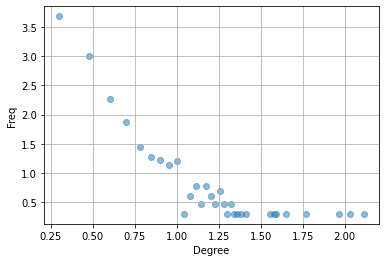

In [40]:
plot_loglog(g.degree())

In [44]:
#edge seq., vertex seq.
len(g.es), len(g.vs)

(4658, 6201)

# Setting the test-set and the potential recommendations

In [12]:
import random
random.seed(1)

p = 0.2
N = len(g.es) #number of nodes
all_idxs = range(N)
test_ids = np.random.choice(a = all_idxs, size = int(p*N), replace=False)

In [13]:
len(g.vs)

6201

In [14]:
g2.delete_vertices(test_ids)

In [46]:
len(g2.vs), len(g2.es)

(5270, 3400)

In [16]:
def find_nodes_at_distance_2(graph):
    """
    starting from a graph this function returns all the nodes at distance 2
    """
    

    all_potential_recommendations = set()
    
    for n1 in graph.vs:
        
        # all the nodes at distance 1
        nodes_at_most_distant_1 = set(graph.neighborhood(vertices = n1, order = 1))

        # all the nodes at distance 1 and distance 2
        nodes_at_most_distant_2 = set(graph.neighborhood(vertices = n1, order = 2))
        
        # only the nodes at distance 2
        only_nodes_at_distance_2 = nodes_at_most_distant_2 - nodes_at_most_distant_1
        
        
        # check if empty set
        if len(only_nodes_at_distance_2) > 0:
            

            for n2 in only_nodes_at_distance_2:
                
                # since n1 is an igraph vertex object, we need to extract the id
                n1_index = n1.index
                
                all_potential_recommendations.add((n1_index, n2))
            
    return all_potential_recommendations

In [18]:
def print_top_k(graph, topk, opt, vid=None):
    """
    we print the top-k nodes with highest degree, pagerank and personalized-pagerank.
    
    Based on the selected option, a different top-k is generated
    """
    if opt == "degree":

      # degree and node-idx
      deg = enumerate(graph.degree())
      # sorting the list "deg" by degree, extracting the top-k
      out = sorted(deg, key = lambda x: x[1], reverse = True)[:topk]
     
    if opt == "pagerank":
        
        pr = enumerate(graph.pagerank())
        # sorting the list "pr" by pagerank, extracting the top-k
        out = sorted(pr, key=lambda tup: tup[1], reverse=True)[:topk]
        
    if opt == "personalized-pr":
        
        # here we need also the argument vid, which corresponds to a node-id
        pr = enumerate(graph.personalized_pagerank(reset_vertices=vid))
        out = sorted(pr, key=lambda tup: tup[1], reverse=True)[:topk]
        
    return out

In [23]:
ground_truth = set()
trainset = set()
for idx, one_edge in enumerate(g.es):
    
    # take n1 and n2 idx from one_edge, that is an igraph edge *object*
    n1 = one_edge.source
    n2 = one_edge.target

    if idx in test_ids:
        
        ground_truth.add((n1, n2, 1))
    else:
        
        trainset.add((n1, n2, 1))

In [24]:
all_potential_recommendations = find_nodes_at_distance_2(g2)

In [25]:
for rec in all_potential_recommendations:
    
    # add to ground truth also the potential nodes
    n1 = rec[0]
    n2 = rec[1]
    
    ground_truth.add((n1,n2,0))

# Personalized PageRank

In [26]:
topkppr = {}
for node in test_ids:
    topkppr[node] = print_top_k(g, 1, 'personalized-pr', vid=node)[0][0]
ppr_df = pd.DataFrame({'node':list(topkppr.keys()), 'recommendation': list(topkppr.values())})
for i in ppr_df.index:
    if ppr_df.loc[i]['node'] == ppr_df.loc[i]['recommendation']:
        ppr_df = ppr_df.drop(i)
#ppr_df

In [27]:
df_test = pd.DataFrame(list(ground_truth), columns=["n1","n2", "edge"])
l = []
for i in df_test.index:
    for j in ppr_df.index:
        if df_test.loc[i]['n1'] == ppr_df.loc[j]['node'] and df_test.loc[i]['n2'] == ppr_df.loc[j]['recommendation']:
            l.append(1)
        else:
            l.append(0)
            break

In [28]:
df_test['rating'] = l

In [29]:
df_test

,n1,n2,edge,rating
0,2258,2335,0,0
1,2690,4296,0,0
2,559,2019,0,0
3,4191,4191,1,0
4,3771,954,0,0
...,...,...,...,...
38388,3136,4305,0,0
38389,3503,1132,0,0
38390,3985,1489,0,0
38391,672,1075,0,0


In [30]:
# number of observations matched by the prediction
right_predictions = len(df_test[df_test['rating']==df_test['edge']])

# accuracy
right_predictions/len(df_test)

0.975750787904045

# Adamic-Adar

In [90]:
def compute_ADA(u,v, graph):
    """
    compute adamic-adar from scratch
    """
    
    # set of neighbors of u
    outlinks_from_u = graph.neighbors(u)

    # set of neighbors of v
    inlinks_to_v = graph.neighbors(v)

    
    # set Z of neighbors of both
    bridges = set(outlinks_from_u).intersection(inlinks_to_v) #set(inlinks_v)
    
    # degree of nodes in set Z
    deg_ = [graph.degree(n) for n in bridges] #graph.degree(bridges)
    
    # computing the reciprocal in log-scale
    out = [1./np.log2(dd+1) for dd in deg_]

    return sum(out)

In [91]:
compute_ADA(80, 3000, g)

0

In [92]:
dictionary = {}
dictofnodes = {}
for n1 in test_ids:
    for n2 in test_ids:
        if n2 != n1:
            if n1 not in list(dictionary.keys()):
                dictionary[n1] = [compute_ADA(n1, n2, g)]
                dictofnodes[n1] = [n2]
            else:
                dictionary[n1].append(compute_ADA(n1, n2, g))
                dictofnodes[n1].append(n2)
#dictionary

# ALS

In [31]:
#adjacency matrix
M = g.get_adjacency().data
M = csr_matrix(M)

In [32]:
M

<6201x6201 sparse matrix of type '<class 'numpy.int64'>'
	with 8632 stored elements in Compressed Sparse Row format>

In [33]:
# here we run the model ALS
model = implicit.als.AlternatingLeastSquares(factors=10, calculate_training_loss=True,  iterations=5)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(M)

In [34]:
def predict_ALS(testset, model):
    """
    predict for a list of observations the score for adding/removing a link
    """

    # initialize the empty list
    all_predictions = []

    # scroll the obs
    for n1,n2, w in testset:
        
        # take here the low-dimensional vectors returned by the matrix factorization
        
        array_n1 = model.user_factors[n1,:]
        array_n2 = model.item_factors[n2,:]

        # multiplying these vectors we generate an approximation for the edge score
        one_p = np.dot(array_n1, array_n2)

        all_predictions.append(one_p)
        
    return all_predictions

In [35]:
# generate the predictions
df_test = pd.DataFrame(list(ground_truth), columns=["n1","n2", "edge"])
all_predictions = predict_ALS(df_test.values, model)

# add predictions to df
df_test["rating"] = all_predictions

# convert predictions to binary values: 0 don't add the edge, 1 add it.
df_test["rating"] = df_test["rating"].apply(lambda x: round(x))

In [36]:
#pd.set_option('display.max_rows', 500)
df_test

,n1,n2,edge,rating
0,2258,2335,0,0
1,2690,4296,0,0
2,559,2019,0,0
3,4191,4191,1,0
4,3771,954,0,0
...,...,...,...,...
38388,3136,4305,0,0
38389,3503,1132,0,0
38390,3985,1489,0,0
38391,672,1075,0,0


In [37]:
# number of observations matched by the prediction
right_predictions = len(df_test[df_test['rating']==df_test['edge']])

# accuracy
right_predictions/len(df_test)

0.9781991508868805